# Training a bunch of models to see if the speed limits sign cleanup helped and by how much

In [ ]:
%load_ext autoreload
%autoreload 2
from fastai.vision.all import *

## Load the data into a Pandas DataFrame

In [ ]:
path = Path('yolo-bbox-crops-aspects')

In [ ]:
fnames = get_image_files(path)

In [ ]:
data = pd.DataFrame(dict(fname = fnames), index = [str(x) for x in fnames])
data['label'] = data.fname.map(lambda x: x.parent.name)
data['photo_id'] = data['fname'].apply(lambda x: re.sub("-[0-9]+.jpg", "", Path(x).name))

In [ ]:
invalid = pd.read_csv('invalid-speed-limits.csv', index_col=0)
data['new_label'] = data['label']
data.loc[invalid.index, 'new_label'] = 'invalid'

In [ ]:
data

,fname,label,photo_id,new_label
yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/a3K73YQChXmdfsn69D1kjA-1.jpg,yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/a3K73YQChXmdfsn69D1kjA-1.jpg,warning--winding-road-first-left--g1,a3K73YQChXmdfsn69D1kjA,warning--winding-road-first-left--g1
yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/l8GLcMia5zPhB7Q1agVYTg-0.jpg,yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/l8GLcMia5zPhB7Q1agVYTg-0.jpg,warning--winding-road-first-left--g1,l8GLcMia5zPhB7Q1agVYTg,warning--winding-road-first-left--g1
yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/BCxKRFT-Wvn49LnVoSlOgw-0.jpg,yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/BCxKRFT-Wvn49LnVoSlOgw-0.jpg,warning--winding-road-first-left--g1,BCxKRFT-Wvn49LnVoSlOgw,warning--winding-road-first-left--g1
yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/5D1e0maBSjs1UaV5tE2MHg-0.jpg,yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/5D1e0maBSjs1UaV5tE2MHg-0.jpg,warning--winding-road-first-left--g1,5D1e0maBSjs1UaV5tE2MHg,warning--winding-road-first-left--g1
yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/Oz7f7PDh0FZogR2Lle9HsQ-1.jpg,yolo-bbox-crops-aspects/warning--winding-road-first-left--g1/Oz7f7PDh0FZogR2Lle9HsQ-1.jpg,warning--winding-road-first-left--g1,Oz7f7PDh0FZogR2Lle9HsQ,warning--winding-road-first-left--g1
...,...,...,...,...
yolo-bbox-crops-aspects/complementary--one-direction-left--g1/jz9ydBI3G46OM_DSDxRI2Q-3.jpg,yolo-bbox-crops-aspects/complementary--one-direction-left--g1/jz9ydBI3G46OM_DSDxRI2Q-3.jpg,complementary--one-direction-left--g1,jz9ydBI3G46OM_DSDxRI2Q,complementary--one-direction-left--g1
yolo-bbox-crops-aspects/complementary--one-direction-left--g1/jjP8oXmH91HYeNRRZy36ig-1.jpg,yolo-bbox-crops-aspects/complementary--one-direction-left--g1/jjP8oXmH91HYeNRRZy36ig-1.jpg,complementary--one-direction-left--g1,jjP8oXmH91HYeNRRZy36ig,complementary--one-direction-left--g1
yolo-bbox-crops-aspects/complementary--one-direction-left--g1/PrXKSuASmK0TB3tqCLVY9A-4.jpg,yolo-bbox-crops-aspects/complementary--one-direction-left--g1/PrXKSuASmK0TB3tqCLVY9A-4.jpg,complementary--one-direction-left--g1,PrXKSuASmK0TB3tqCLVY9A,complementary--one-direction-left--g1
yolo-bbox-crops-aspects/complementary--one-direction-left--g1/DdilxFWJ13kSsBTDlCNCcg-2.jpg,yolo-bbox-crops-aspects/complementary--one-direction-left--g1/DdilxFWJ13kSsBTDlCNCcg-2.jpg,complementary--one-direction-left--g1,DdilxFWJ13kSsBTDlCNCcg,complementary--one-direction-left--g1


## Prepare the train/validation split

In [ ]:
data['valid'] = False

In [ ]:
# Split each class equally into the train and validation set
# This includes the 'invalid' label which will be represented in both splits
def set_valid_split(df, sel, p=0.2):
    sel = random.sample(list(df.index[sel]), math.floor(sel.sum() * p))
    df.loc[sel, 'valid'] = True

random.seed(42)
for label in data['new_label'].unique():
    set_valid_split(data, data['new_label'] == label)
data.loc[data['label'] == 'other-sign', 'valid'] = False

In [ ]:
# verify we did the split correctly
data.groupby('new_label').mean().sort_values('valid')

,valid
new_label,
regulatory--truck-speed-limit-60--g1,0.000
information--dead-end-except-bicycles--g1,0.000
regulatory--end-of-maximum-speed-limit-70--g1,0.000
other-sign,0.000
warning--horizontal-alignment-right--g3,0.125
...,...
warning--height-restriction--g2,0.200
warning--hairpin-curve-right--g4,0.200
regulatory--no-parking-or-no-stopping--g1,0.200


## Data augmentation

In [ ]:
from albumentations import Blur

In [ ]:
class AlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

## Balance the classes during training

In [ ]:
def sample_epoch(self):
    item_labels = self.items['label']
    label_freq = {label:count for label, count in zip(*np.unique(item_labels, return_counts=True))}
    weights = [1/label_freq[label] for label in item_labels]
    return random.choices(range(len(self.items)), weights=weights, k=len(self.items))

def fix_balance(dls):
    dls.train.get_idxs = types.MethodType(sample_epoch, dls.train)

## Load predictions into a DataFrame for further analysis

In [ ]:
def get_predictions(learn):
    preds,y,py,losses = learn.get_preds(with_loss=True, with_decoded=True)
    val = pd.DataFrame(index=learn.dls[1].items.index)
    val['pred'] = py
    val['pred'] = val['pred'].map(lambda x: learn.dls.vocab[x])
    val['loss'] = -losses
    return val

## Train on the original labels

In [ ]:
dls = ImageDataLoaders.from_df(
    data, label_col='label', valid_col='valid',
    bs=1024,
    item_tfms=[AlbumentationsTransform(Blur(blur_limit=5, p=0.25))],
    batch_tfms=aug_transforms(do_flip=False),
)
fix_balance(dls)

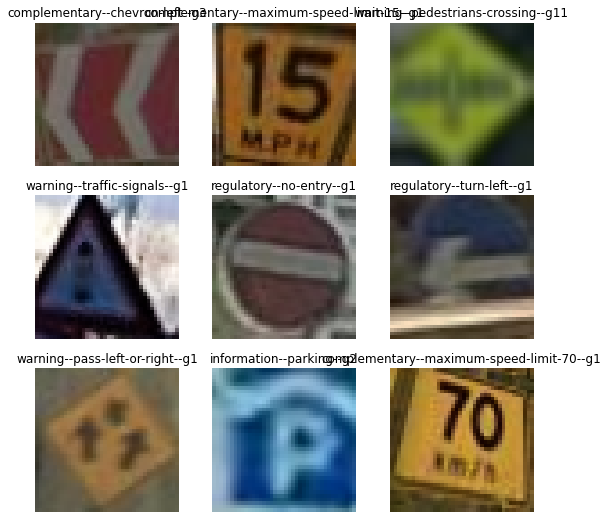

In [ ]:
dls.show_batch()

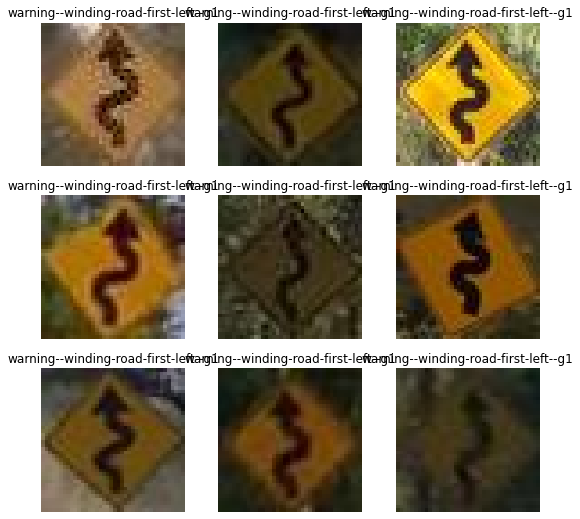

In [ ]:
dls.valid.show_batch()

We train 20 models to average out the results over multiple random model initializations.

In [ ]:
!mkdir -p speed-limit-experiment/

In [ ]:
for i in range(0,20):
    learn = vision_learner(dls, resnet50, metrics=[error_rate])
    gc.collect()
    learn.fine_tune(15)
    learn.export(f'speed-limit-experiment/original-model-{i}.model')
    get_predictions(learn).to_csv(f'speed-limit-experiment/original-predictions-{i}.csv')

epoch,train_loss,valid_loss,error_rate,time
0,3.192685,2.184022,0.565504,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.377607,1.203649,0.343808,00:45
1,0.694049,0.738440,0.215885,00:45
2,0.352508,0.516270,0.145717,00:45
3,0.225299,0.487573,0.134166,00:45
4,0.156069,0.446337,0.114794,00:45
5,0.119194,0.420491,0.100588,00:45
6,0.097342,0.403449,0.095710,00:44
7,0.075003,0.381256,0.086670,00:44
8,0.059365,0.372755,0.081145,00:45
9,0.048652,0.367208,0.082365,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.174926,2.199097,0.568948,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.385972,1.171804,0.331109,00:44
1,0.692231,0.717439,0.206916,00:44
2,0.358379,0.534532,0.153322,00:45
3,0.223138,0.468127,0.126130,00:45
4,0.160181,0.435611,0.108337,00:45
5,0.121512,0.413125,0.100014,00:45
6,0.094991,0.395330,0.093557,00:45
7,0.075312,0.389428,0.090400,00:45
8,0.058431,0.369612,0.083728,00:45
9,0.047807,0.365306,0.078419,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.176069,2.207025,0.573468,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.368092,1.179003,0.336992,00:45
1,0.691850,0.719519,0.208208,00:45
2,0.355702,0.555411,0.153035,00:45
3,0.222222,0.483391,0.128856,00:45
4,0.162077,0.430381,0.108839,00:45
5,0.119015,0.432722,0.107978,00:44
6,0.097629,0.407411,0.096499,00:45
7,0.073746,0.385302,0.087244,00:44
8,0.059411,0.374484,0.085091,00:45
9,0.047081,0.374349,0.078993,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.173688,2.178004,0.567585,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.378958,1.171531,0.335342,00:45
1,0.694534,0.722618,0.209427,00:45
2,0.354963,0.536154,0.151959,00:44
3,0.218793,0.484752,0.130722,00:44
4,0.163539,0.443117,0.113718,00:44
5,0.113952,0.433729,0.102669,00:45
6,0.093413,0.393414,0.091118,00:44
7,0.072247,0.388897,0.088822,00:45
8,0.060516,0.369948,0.084517,00:43
9,0.043736,0.363622,0.079567,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.179272,2.209402,0.577127,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.383527,1.178115,0.337638,00:44
1,0.690058,0.730911,0.212154,00:45
2,0.355031,0.528857,0.147797,00:45
3,0.220435,0.517628,0.140910,00:45
4,0.159808,0.439856,0.108050,00:44
5,0.122769,0.421914,0.099943,00:45
6,0.092904,0.396862,0.092911,00:44
7,0.077685,0.389934,0.087817,00:45
8,0.060084,0.386134,0.085809,00:45
9,0.048407,0.382947,0.083943,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.161433,2.146915,0.558904,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.384060,1.173953,0.333907,00:45
1,0.703267,0.718627,0.207275,00:44
2,0.359820,0.528628,0.149232,00:45
3,0.225484,0.458652,0.125915,00:45
4,0.154711,0.433431,0.109557,00:43
5,0.125361,0.407817,0.098866,00:45
6,0.094664,0.391175,0.089683,00:45
7,0.075622,0.382855,0.088320,00:45
8,0.058633,0.377226,0.084876,00:43
9,0.045305,0.386709,0.084445,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.168286,2.169814,0.559334,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.381064,1.181313,0.337423,00:45
1,0.701390,0.723410,0.211221,00:45
2,0.355686,0.531959,0.149519,00:45
3,0.222372,0.462371,0.124193,00:45
4,0.156142,0.449691,0.115081,00:44
5,0.121365,0.407323,0.100588,00:44
6,0.093898,0.388316,0.092337,00:44
7,0.075224,0.384541,0.089324,00:45
8,0.059732,0.375186,0.084732,00:44
9,0.044980,0.364873,0.079423,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.171444,2.185405,0.565935,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.373796,1.164940,0.331037,00:43
1,0.688718,0.713164,0.205697,00:44
2,0.356304,0.539019,0.152461,00:45
3,0.224121,0.467126,0.126560,00:45
4,0.159840,0.437951,0.111852,00:45
5,0.117845,0.415125,0.097144,00:45
6,0.093920,0.395662,0.091979,00:45
7,0.074808,0.378356,0.087172,00:45
8,0.058006,0.372317,0.082293,00:43
9,0.046959,0.367113,0.081719,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.173919,2.172160,0.563639,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.369252,1.168801,0.332329,00:45
1,0.697109,0.700896,0.200100,00:45
2,0.355605,0.540868,0.150667,00:44
3,0.220663,0.492934,0.135457,00:45
4,0.160036,0.419316,0.107045,00:45
5,0.124705,0.403736,0.099225,00:44
6,0.093084,0.398253,0.094705,00:44
7,0.069612,0.364618,0.086239,00:45
8,0.060677,0.378752,0.083800,00:45
9,0.044365,0.366204,0.078706,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.176054,2.184530,0.563926,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.375034,1.164790,0.331540,00:44
1,0.692985,0.737924,0.216243,00:45
2,0.359426,0.557801,0.159779,00:44
3,0.221181,0.465276,0.123188,00:45
4,0.163570,0.454880,0.117520,00:45
5,0.120837,0.426239,0.103889,00:45
6,0.095676,0.402124,0.095925,00:44
7,0.073218,0.398162,0.093127,00:44
8,0.061291,0.377943,0.087172,00:45
9,0.046751,0.363213,0.080643,00:45


## Train on the fixed dataset

In [ ]:
dls = ImageDataLoaders.from_df(
    data[data['new_label'] != 'invalid'], label_col='label', valid_col='valid',
    bs=1024,
    item_tfms=[AlbumentationsTransform(Blur(blur_limit=5, p=0.25))],
    batch_tfms=aug_transforms(do_flip=False),
)
fix_balance(dls)

In [ ]:
for i in range(0,20):
    learn = vision_learner(dls, resnet50, metrics=[error_rate])
    gc.collect()
    learn.fine_tune(15)
    learn.export(f'speed-limit-experiment/fixed-model-{i}.model')
    get_predictions(learn).to_csv(f'speed-limit-experiment/fixed-predictions-{i}.csv')

epoch,train_loss,valid_loss,error_rate,time
0,3.165074,2.174655,0.569279,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.369935,1.161217,0.329518,00:45
1,0.693338,0.703007,0.204060,00:45
2,0.353126,0.554561,0.153746,00:45
3,0.215826,0.452971,0.121428,00:45
4,0.152556,0.429023,0.108832,00:44
5,0.119524,0.406994,0.098971,00:45
6,0.091822,0.386059,0.091845,00:44
7,0.073158,0.383607,0.087814,00:45
8,0.059042,0.367536,0.081840,00:44
9,0.045261,0.359216,0.078097,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.159712,2.187937,0.571223,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.378376,1.188342,0.342475,00:45
1,0.686918,0.693127,0.201108,00:44
2,0.351692,0.535942,0.152091,00:45
3,0.221238,0.467050,0.126323,00:44
4,0.153053,0.418011,0.107320,00:44
5,0.116906,0.397347,0.098467,00:44
6,0.091909,0.393237,0.092133,00:44
7,0.074086,0.353737,0.084215,00:45
8,0.058219,0.357700,0.082775,00:45
9,0.043417,0.352780,0.077089,00:44


epoch,train_loss,valid_loss,error_rate,time
0,3.158712,2.175409,0.565897,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.356512,1.172474,0.339380,00:44
1,0.692822,0.695171,0.203556,00:45
2,0.351920,0.527705,0.151443,00:45
3,0.219346,0.474355,0.127474,00:45
4,0.149953,0.420947,0.107968,00:45
5,0.118345,0.409573,0.100626,00:44
6,0.091391,0.377070,0.088390,00:44
7,0.074252,0.365777,0.084503,00:45
8,0.055722,0.364419,0.083063,00:44
9,0.046963,0.348952,0.077449,00:44


epoch,train_loss,valid_loss,error_rate,time
0,3.172155,2.173381,0.570863,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.372481,1.161872,0.334629,00:45
1,0.691666,0.714397,0.207515,00:45
2,0.350652,0.522056,0.146045,00:44
3,0.220477,0.466756,0.126323,00:45
4,0.155243,0.428865,0.107176,00:43
5,0.117976,0.396841,0.098683,00:45
6,0.094536,0.394254,0.093500,00:44
7,0.074631,0.381983,0.086446,00:44
8,0.058300,0.349069,0.077809,00:43
9,0.045850,0.366574,0.081624,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.169667,2.178636,0.566544,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.373396,1.172064,0.337940,00:44
1,0.687295,0.708424,0.204995,00:44
2,0.352746,0.537814,0.151515,00:44
3,0.219143,0.475548,0.127042,00:45
4,0.155818,0.433766,0.111567,00:44
5,0.121414,0.404443,0.100986,00:45
6,0.095548,0.416137,0.098683,00:43
7,0.070188,0.373929,0.087022,00:45
8,0.060596,0.372546,0.082704,00:44
9,0.046868,0.356085,0.077377,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.165860,2.167290,0.560066,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.373523,1.156174,0.332614,00:45
1,0.692914,0.693891,0.200173,00:45
2,0.350101,0.512189,0.143166,00:45
3,0.216021,0.443711,0.116965,00:45
4,0.160344,0.422853,0.108256,00:45
5,0.119554,0.399258,0.095444,00:44
6,0.091287,0.382306,0.090405,00:45
7,0.071596,0.368574,0.086374,00:44
8,0.056568,0.361634,0.081336,00:45
9,0.043164,0.349321,0.076945,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.172179,2.173607,0.570215,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.359136,1.163863,0.333621,00:44
1,0.689941,0.706387,0.206003,00:45
2,0.356080,0.526914,0.150148,00:44
3,0.218073,0.448983,0.117541,00:45
4,0.158387,0.427661,0.108472,00:45
5,0.117850,0.379300,0.093860,00:45
6,0.093291,0.381380,0.093068,00:45
7,0.076133,0.378183,0.086374,00:45
8,0.054461,0.372413,0.081984,00:45
9,0.045711,0.350690,0.075146,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.174947,2.140594,0.555819,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.356366,1.159775,0.331606,00:45
1,0.687512,0.710875,0.206075,00:45
2,0.350387,0.562120,0.158209,00:45
3,0.215358,0.463586,0.123659,00:45
4,0.160279,0.426838,0.109048,00:45
5,0.118933,0.423424,0.105881,00:45
6,0.090056,0.381372,0.090549,00:44
7,0.070498,0.383778,0.090333,00:43
8,0.054578,0.381856,0.083279,00:45
9,0.044950,0.367892,0.080832,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.169443,2.157375,0.559850,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.367625,1.166459,0.327863,00:45
1,0.684872,0.715618,0.206003,00:45
2,0.354999,0.536684,0.150939,00:44
3,0.223673,0.472165,0.124883,00:45
4,0.159079,0.414919,0.107104,00:43
5,0.119334,0.394654,0.096092,00:45
6,0.092748,0.383622,0.091269,00:44
7,0.072292,0.387036,0.089398,00:45
8,0.054207,0.375709,0.082128,00:45
9,0.045950,0.373439,0.081696,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.155058,2.217402,0.585331,00:38


epoch,train_loss,valid_loss,error_rate,time
0,1.354779,1.149691,0.328151,00:43
1,0.688096,0.715962,0.212193,00:45
2,0.348366,0.545739,0.151011,00:43
3,0.220869,0.459813,0.123300,00:44
4,0.156962,0.427036,0.110055,00:45
5,0.116562,0.404608,0.098107,00:43
6,0.091828,0.386652,0.092709,00:45
7,0.074411,0.374308,0.084071,00:45
8,0.059618,0.371550,0.082775,00:44
9,0.043980,0.359426,0.077953,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.158238,2.166784,0.566400,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.363437,1.164027,0.332686,00:45
1,0.688868,0.707417,0.205931,00:45
2,0.353657,0.527621,0.148996,00:44
3,0.218487,0.453320,0.124451,00:44
4,0.160420,0.415241,0.105737,00:45
5,0.119217,0.388637,0.097963,00:44
6,0.090382,0.378435,0.090765,00:45
7,0.074452,0.355894,0.081840,00:44
8,0.057196,0.367012,0.083351,00:45
9,0.046580,0.354262,0.076225,00:43


epoch,train_loss,valid_loss,error_rate,time
0,3.171612,2.172088,0.564745,00:39


epoch,train_loss,valid_loss,error_rate,time
0,1.367343,1.176270,0.335349,00:45
1,0.692805,0.717707,0.208018,00:45
2,0.355417,0.528593,0.148924,00:45
3,0.222534,0.491414,0.134888,00:44
4,0.154434,0.412076,0.109120,00:44
5,0.115308,0.409193,0.101418,00:45
6,0.092664,0.380644,0.092565,00:44
7,0.071367,0.390106,0.090333,00:45
8,0.056844,0.362097,0.081048,00:45
9,0.044513,0.355633,0.077233,00:44


## Let's do the analysis

First let's check the error rates on one of the original models.

In [ ]:
df = pd.read_csv(f'speed-limit-experiment/original-predictions-0.csv', index_col=0)
df = pd.concat([data.loc[df.index], df], axis=1)

In [ ]:
df[df['new_label'] == 'invalid'].head()

,fname,label,photo_id,new_label,valid,orig_errs,fixed_errs,pred,loss
yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-120--g1/2fLoo6nvIZt8D7hwnUAyPw-2.jpg,yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-120--g1/2fLoo6nvIZt8D7hwnUAyPw-2.jpg,regulatory--maximum-speed-limit-120--g1,2fLoo6nvIZt8D7hwnUAyPw,invalid,True,0.0,NaN,regulatory--maximum-speed-limit-120--g1,-0.055474
yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-70--g1/wd2sOhwuL6iY4Av5_5wFuA-4.jpg,yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-70--g1/wd2sOhwuL6iY4Av5_5wFuA-4.jpg,regulatory--maximum-speed-limit-70--g1,wd2sOhwuL6iY4Av5_5wFuA,invalid,True,0.0,NaN,regulatory--maximum-speed-limit-70--g1,-0.002409
yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-70--g1/YX-kKnj_qcx6ahJaTMeQ_Q-2.jpg,yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-70--g1/YX-kKnj_qcx6ahJaTMeQ_Q-2.jpg,regulatory--maximum-speed-limit-70--g1,YX-kKnj_qcx6ahJaTMeQ_Q,invalid,True,0.0,NaN,regulatory--maximum-speed-limit-70--g1,-0.001256
yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-60--g1/6YTKge0mwQoEOqVoX8bQrQ-8.jpg,yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-60--g1/6YTKge0mwQoEOqVoX8bQrQ-8.jpg,regulatory--maximum-speed-limit-60--g1,6YTKge0mwQoEOqVoX8bQrQ,invalid,True,0.0,NaN,regulatory--maximum-speed-limit-60--g1,-0.020788
yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-60--g1/DvyzaUJFVpm2m4TCFe9XZg-5.jpg,yolo-bbox-crops-aspects/regulatory--maximum-speed-limit-60--g1/DvyzaUJFVpm2m4TCFe9XZg-5.jpg,regulatory--maximum-speed-limit-60--g1,DvyzaUJFVpm2m4TCFe9XZg,invalid,True,0.0,NaN,regulatory--maximum-speed-limit-60--g1,-0.016922


In [ ]:
# Overall prediction error rate
print(f"{(df['label'] != df['pred']).mean() * 100:.2f} %")

7.28 %


In [ ]:
# Prediction error rate for speed limits (ignoring the ones we deemed invalid)
speed_limits = df[df['new_label'].str.contains('speed')]
print(f"{(speed_limits['label'] != speed_limits['pred']).mean() * 100:.2f} %")

8.79 %


In [ ]:
def load_preds(fname):
    df = pd.read_csv(fname, index_col=0)
    return pd.concat([data.loc[df.index], df], axis=1)
    
def calc_error_rate(df):
    return (df['label'] != df['pred']).mean()

def calc_stats(fname):
    df = load_preds(fname)
    sel = df['label'].str.contains('speed')
    return calc_error_rate(df), calc_error_rate(df[sel]), calc_error_rate(df[(~sel)])

In [ ]:
orig_errs = np.array([calc_stats(f'speed-limit-experiment/original-predictions-{i}.csv') for i in range(20)])

In [ ]:
fixed_errs = np.array([calc_stats(f'speed-limit-experiment/fixed-predictions-{i}.csv') for i in range(20)])

## The results

In [ ]:
# Some population statistics
speed_sel = data['label'].str.contains('speed')
print(f"""\
The speed limits signs are {(data['label'].str.contains('speed')).mean() * 100:.2f}% of the whole dataset
and we corrected {(data.loc[speed_sel, 'new_label'] == 'invalid').mean() * 100:.2f}% of these
so we fixed the labels for {(data['new_label'] == 'invalid').mean() * 100:.2f}% of all the traffic signs.""")

The speed limits signs are 3.70% of the whole dataset
and we corrected 2.97% of these
so we fixed the labels for 0.11% of all the traffic signs.


The total model error rate went down from 7.28 to 7.05 (by 0.23)


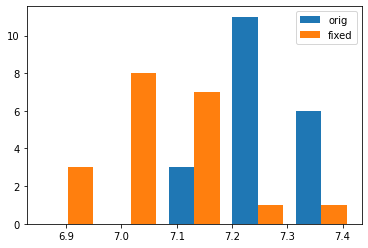

In [ ]:
err = orig_errs[:,0].mean() * 100, fixed_errs[:,0].mean() * 100
print(f"The total model error rate went down from {err[0]:.2f} to {err[1]:.2f} (by {err[0] - err[1]:.2f})")
plt.hist([orig_errs[:,0] * 100, fixed_errs[:,0] * 100], bins=5, label=['orig','fixed']); plt.legend();

The model error rate for speed signs went down from 10.42 to 8.49 (by 1.93)


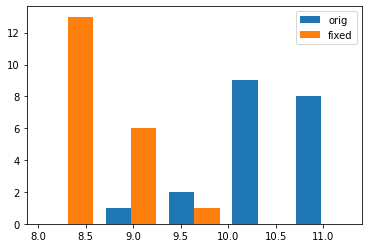

In [ ]:
err = orig_errs[:,1].mean() * 100, fixed_errs[:,1].mean() * 100
print(f"The model error rate for speed signs went down from {err[0]:.2f} to {err[1]:.2f} (by {err[0] - err[1]:.2f})")
plt.hist([orig_errs[:,1] * 100, fixed_errs[:,1] * 100], bins=5, label=['orig','fixed']); plt.legend();

The model error rate for all the other signs went down from 6.90 to 6.88 (by 0.02)


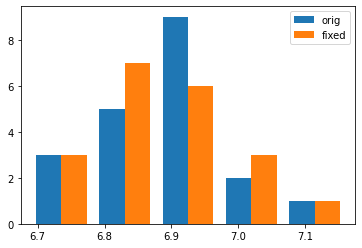

In [ ]:
err = orig_errs[:,2].mean() * 100, fixed_errs[:,2].mean() * 100
print(f"The model error rate for all the other signs went {'down' if err[0] > err[1] else 'up'} from {err[0]:.2f} to {err[1]:.2f} (by {err[0] - err[1]:.2f})")
plt.hist([orig_errs[:,2] * 100, fixed_errs[:,2] * 100], bins=5, label=['orig','fixed']); plt.legend();